<center> 
    <h1> MBTI Personality Trait Classification using Twitter  </h1>
    <h4> <i> Author: Pavan Kumar K N </i>  </h4>
 </center>



In [1]:
#
# * File:    classic_persona.py
# *
# * Author1:  Pavan Kumar K N (pavankumar.karkekopp@ucalgary.ca)
# * Date:     20th May 2019
# * Summary of File:
# * Explore mbti_1.csv file acquired from https://www.kaggle.com/datasnaek/mbti-type
# * Apply state-of-the-art reported publicly
# * Build classifier model that is better using machine learning techniques

#Just making sure the right environment is running this script
import sys
sys.executable
    

'C:\\Users\\pavankumar.karkekopp\\.conda\\envs\\python35\\python.exe'

### Python libraries

In [2]:
#Read Data
import numpy as np
import pandas as pd
import sklearn
import re

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset Description

In [3]:
#Read the dataset
mbti_data = pd.read_csv("data/mbti_1.csv")

#### Data Preview

In [4]:
#Print first 5 entries in the dataset
mbti_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
raw_posts = mbti_data.posts.values

In [6]:
#Split posts by the delimiter, which is ||| as we can see in row 0 and 4 above
filtered_posts = [p.split("|||") for p in raw_posts]

In [7]:
#Example of two tweets from row 0
for i in range(5):
    print("Tweet #{}:   {}".format(i+1,filtered_posts[0][i]))


Tweet #1:   'http://www.youtube.com/watch?v=qsXHcwe3krw
Tweet #2:   http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg
Tweet #3:   enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks
Tweet #4:   What has been the most life-changing experience in your life?
Tweet #5:   http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.


#### MBTI Types Distribution in Data

In [8]:
count_types = mbti_data['type'].value_counts()

In [9]:
count_types = round(count_types/sum(count_types),4) * 100

In [10]:
count_types

INFP    21.12
INFJ    16.95
INTP    15.03
INTJ    12.58
ENTP     7.90
ENFP     7.78
ISTP     3.88
ISFP     3.12
ENTJ     2.66
ISTJ     2.36
ENFJ     2.19
ISFJ     1.91
ESTP     1.03
ESFP     0.55
ESFJ     0.48
ESTJ     0.45
Name: type, dtype: float64

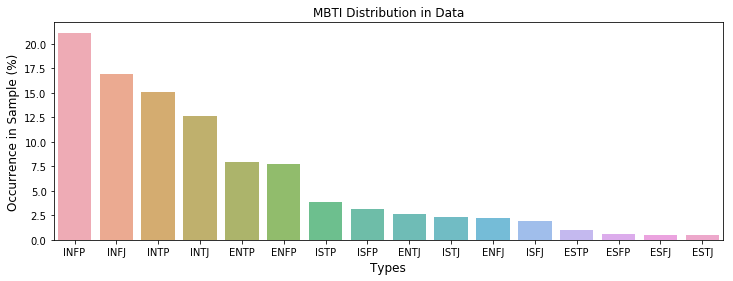

In [11]:
plt.figure(figsize=(12,4))
sns.barplot(count_types.index, count_types.values, alpha=0.8)
plt.ylabel('Occurrence in Sample (%)', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.title("MBTI Distribution in Data")
plt.show()

##### Unbalanced Dataset
Looking at the barplot, we see that the dataset is unbalanced and we need to take measures to correct for this eg. SMOTE (Synthetic Minority Oversampling Technique) and through k-fold cross-validation of model results

#### MBTI Types Distribution in General Population
https://www.myersbriggs.org/my-mbti-personality-type/my-mbti-results/how-frequent-is-my-type.htm?bhcp=1

In [12]:
genpop_types = count_types

In [13]:
genpop_types['ISTJ'] = 11.6
genpop_types['ISFJ'] = 13.8
genpop_types['INFJ'] = 1.5
genpop_types['INTJ'] = 2.1
genpop_types['ISTP'] = 5.4
genpop_types['ISFP'] = 8.8
genpop_types['INFP'] = 4.4
genpop_types['INTP'] = 3.3
genpop_types['ESTP'] = 4.3
genpop_types['ESFP'] = 8.5
genpop_types['ENFP'] = 8.1
genpop_types['ENTP'] = 3.2
genpop_types['ESTJ'] = 8.7
genpop_types['ESFJ'] = 12.3
genpop_types['ENFJ'] = 2.5
genpop_types['ENTJ'] = 1.8

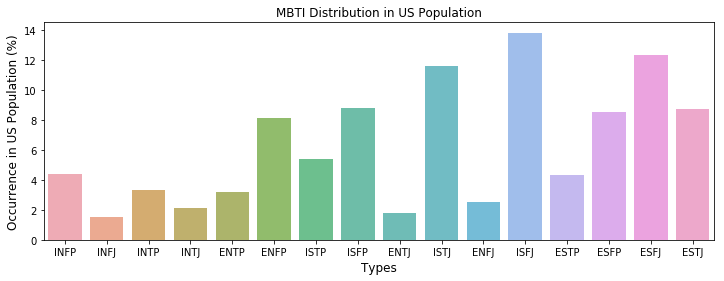

In [14]:
plt.figure(figsize=(12,4))
sns.barplot(genpop_types.index, genpop_types.values, alpha=0.8)
plt.ylabel('Occurrence in US Population (%)', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.title("MBTI Distribution in US Population")
plt.show()

Create 4 bit binary encoding of the class labels

In [15]:
def encode_types(row):
    t=row['type']

    I = 0
    N = 0
    T = 0
    J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('Could not identify label for I-E')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('Could not identify label for N-S')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('Could not identify label for T-F')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('Could not identify label for J-P')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

In [17]:
mbti_data_encoded = mbti_data.join(mbti_data.apply(lambda row: encode_types(row), axis=1))

In [18]:
mbti_data_encoded.head()

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [19]:
num_I = mbti_data_encoded['IE'].value_counts()[0]
num_E = mbti_data_encoded['IE'].value_counts()[1]
num_N = mbti_data_encoded['NS'].value_counts()[0]
num_S = mbti_data_encoded['NS'].value_counts()[1]
num_T = mbti_data_encoded['TF'].value_counts()[0]
num_F = mbti_data_encoded['TF'].value_counts()[1]
num_J = mbti_data_encoded['JP'].value_counts()[0]
num_P = mbti_data_encoded['JP'].value_counts()[1]

In [20]:
print ("Introversion (I) /  Extroversion (E):\t {} / {} ({}% / {}%)".format(num_I, num_E, round(num_I/(num_I+num_E)*100 ,2),round(num_E/(num_I+num_E)*100,2)))
print ("INtuition (N) – Sensing (S):\t {} / {} ({}% / {}%)".format(num_N, num_S, round(num_N/(num_N+num_S)*100 ,2),round(num_S/(num_N+num_S)*100,2)))
print ("Thinking (T) – Feeling (F):\t {} / {} ({}% / {}%)".format(num_T, num_F, round(num_T/(num_T+num_F)*100 ,2),round(num_F/(num_T+num_F)*100,2)))
print ("Judging (J) – Perceiving (P):\t {} / {} ({}% / {}%)".format(num_J, num_P, round(num_J/(num_J+num_P)*100 ,2),round(num_P/(num_J+num_P)*100,2)))

Introversion (I) /  Extroversion (E):	 1999 / 6676 (23.04% / 76.96%)
INtuition (N) – Sensing (S):	 1197 / 7478 (13.8% / 86.2%)
Thinking (T) – Feeling (F):	 4694 / 3981 (54.11% / 45.89%)
Judging (J) – Perceiving (P):	 5241 / 3434 (60.41% / 39.59%)


#### Pearson Feature Coorrelation

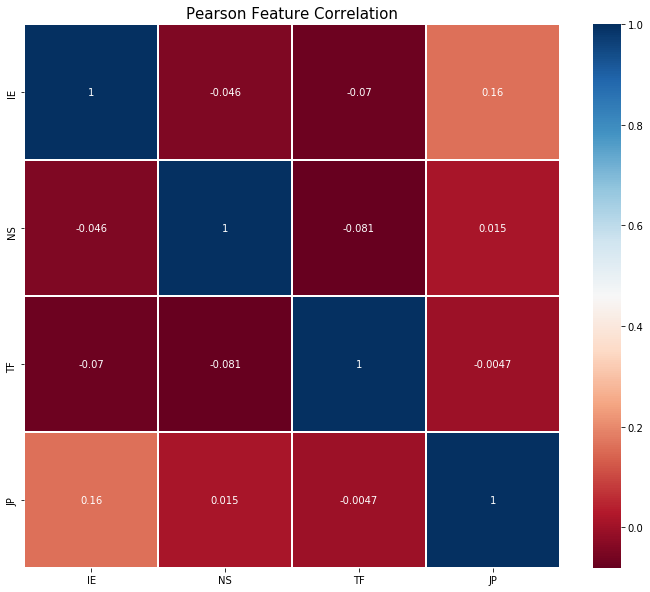

In [21]:
mbti_data_encoded[['IE','NS','TF','JP']].corr()

cmap = plt.cm.RdBu
corr = mbti_data_encoded[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Pearson Feature Correlation', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

This makes sense as we hope that each of the dimensions are unique and uncorrelated in expressing a person's psychology

In [22]:
#Function to binarize the types into simple lists instead of pandas.series
personality_binary = {'I':1, 'E':0, 'N':1,'S':0, 'T':1, 'F':0, 'J':1, 'P': 0}
binary_personality = [{1:'I', 0:'E'}, 
                      {1:'N', 0:'S'},
                      {1:'T', 0:'F'},
                      {1:'J', 0:'P'}]

In [23]:
def translate_personality(personality):
    # transform mbti to binary vector
    return [personality_binary[l] for l in personality]


def translate_binary(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += binary_personality[i][l]
    return s



In [24]:
d = mbti_data_encoded.head(4)
list_personality_bin = np.array([translate_personality(p) for p in d.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[1 1 0 1]
 [0 1 1 0]
 [1 1 1 0]
 [1 1 1 1]]


### Data Preprocessing
* Remove urls
* Keep only words and make it lowercase
* Lemmatize each word
* Remove MBTI profiles strings. Too many appear in the posts!

In [25]:
#List of strings to remove from the corpus
unique_type_list = ['INFJ', 
                    'ENTP', 
                    'INTP', 
                    'INTJ', 
                    'ENTJ', 
                    'ENFJ', 
                    'INFP', 
                    'ENFP',
                    'ISFP', 
                    'ISTP', 
                    'ISFJ', 
                    'ISTJ', 
                    'ESTP', 
                    'ESFP', 
                    'ESTJ', 
                    'ESFJ']

unique_type_list = [x.lower() for x in unique_type_list]

# Initialize for Lemmatization
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def pre_process_data(data, remove_stop_words = True, remove_mbti_profiles = True):
    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in stopwords.words("english")])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        type_labelized = translate_personality(row[1].type)
        list_personality.append(type_labelized)
        list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality


In [ ]:
list_posts, list_personality  = pre_process_data(mbti_data_encoded, remove_stop_words=True)

1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows


NameError: name 'list_posts' is not defined